In [1]:
#imports

import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf

# hs to force keras to use tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

# for logging
from time import time
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [6]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3



#TRAIN_PATH = '/home/hooman/dataPreparation/hsTrainingSetBucyrusAndPnH/unet/randomCroppedImages/'
#MASK_PATH  = '/home/hooman/dataPreparation/hsTrainingSetBucyrusAndPnH/unet/randomCroppedMasks/'
TRAIN_PATH = '/home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/randomCroppedImages/'

MASK_PATH  = '/home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/randomCroppedMasks/'



warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [7]:
# Get train IDs
#train_ids = os.listdir(TRAIN_PATH)

# so that we only use images we have labels for:
train_ids = os.listdir(MASK_PATH)
print(len(train_ids))

12002


In [ ]:
fileName = '1_20180703-171700_1001n0_7319.png'

img = cv2.imread('/home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/randomCroppedImages/' + fileName)

mask = cv2.imread('/home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/full-masks_withInapp/' + fileName)
mask.dtype='uint8'



plt.imshow(img)
plt.title('img')
plt.show()

plt.imshow(mask*255)
plt.title('mask')
plt.show()


In [ ]:



# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)

for n, fileName in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    try:
        #img = imread(TRAIN_PATH + fileName)[:,:,:IMG_CHANNELS]
        #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        img = cv2.imread(TRAIN_PATH + fileName)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        
        X_train[n] = img
        
        
        mask = cv2.imread(MASK_PATH + fileName)
        mask.dtype='uint8'
        plt.imshow(mask)
        plt.title('mask')
        plt.show()
        mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))

        Y_train[n] = mask
    except:
        print("could not read file: " + fileName + "\n")

In [8]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for n, fileName in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    try:
        img = imread(TRAIN_PATH + fileName)[:,:,:IMG_CHANNELS]

        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        mask_ = imread(MASK_PATH + fileName )

        #expand dim just converts the (h,w,) image to (h,w,1) look at above for experimentation with np.expand_dim
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)

        #hs this in effect adds all the masks together into one mask of the same size.Since masks are bindary.
        mask = np.maximum(mask, mask_)
        Y_train[n] = mask
    except:
        print("could not read file: " + fileName + "\n")

100%|██████████| 12002/12002 [00:57<00:00, 207.33it/s]


In [9]:
# hs shuffle the data to randomize it 

s = np.arange(X_train.shape[0])
np.random.shuffle(s)

X_train = X_train[s, :, :,:]
Y_train = Y_train[s, :, :,:]

In [10]:
print(len(Y_train))

12002


In [11]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

Let's see if things look all right by drawing some random images and their associated masks.

/home/hooman/anaconda3/envs/fullAlgo/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/hooman/anaconda3/envs/fullAlgo/lib/python3.5/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


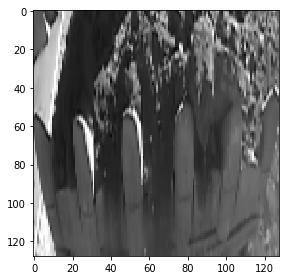

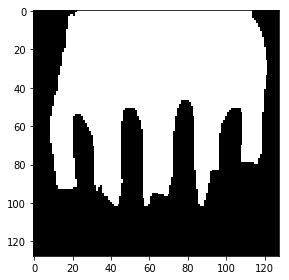

In [13]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [14]:
X_train[ix].shape

(128, 128, 3)

# <font color='blue'> Model Definitions

## My U-Net


![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [15]:
## hsUnet single class on cropped images resized to 128*128
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

# <font color='blue'> Training

In [16]:
# Fit model. I trained my models with batch_size=64 but vesUNet can only be trained with 32 apparently
tensorboard = TensorBoard(log_dir="/home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/trainingLogs/{}".format(time()))

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/model-hsUNet-Backhoe-try4-1chan.h5', verbose=1, save_best_only=True)

results = model.fit(X_train, Y_train, validation_split=0.05, batch_size=4, epochs=500, 
                    callbacks=[earlystopper, checkpointer, tensorboard])

Instructions for updating:
Use the retry module or similar alternatives.
Train on 11401 samples, validate on 601 samples
Epoch 1/500
11401/11401 [==============================] - 57s 5ms/step - loss: 0.5027 - mean_iou: 0.3958 - val_loss: 0.4963 - val_mean_iou: 0.3951

Epoch 00001: val_loss improved from inf to 0.49631, saving model to /home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/model-hsUNet-Backhoe-try4-1chan.h5
Epoch 2/500
11401/11401 [==============================] - 55s 5ms/step - loss: 0.4602 - mean_iou: 0.3991 - val_loss: 0.4042 - val_mean_iou: 0.4065

Epoch 00002: val_loss improved from 0.49631 to 0.40416, saving model to /home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/model-hsUNet-Backhoe-try4-1chan.h5
Epoch 3/500
11401/11401 [==============================] - 55s 5ms/step - loss: 0.3614 - mean_iou: 0.4211 - val_loss: 0.3403 - val_mean_i

# <font color='blue'> Making Predictions

In [18]:
# loading test data in a dictionary

testImagesPath = '/home/hooman/backhoeOpticalScene/testData/'
test_ids = os.listdir(testImagesPath)

testImages = {}
testLabels = {}

for n, fileName in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = cv2.imread(testImagesPath + fileName)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    #img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    testImages[fileName] = img
    
    #plt.imshow(img)
    #plt.title('image')
    #plt.show()
    
    
    #img = imread(testImagesPath + fileName)
    #testImages[fileName] = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    
print("loaded " + str(len(testImages)) + "  images for testing.")

100%|██████████| 53/53 [00:00<00:00, 235.85it/s]

loaded 53  images for testing.


1_20180703-134700_1001n0_3696.png


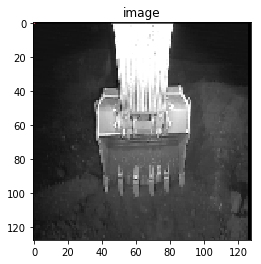

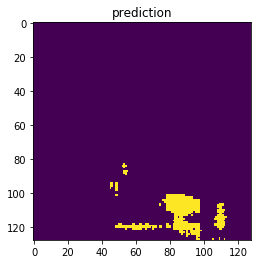

FMDL_2018.08.07_16.11.41.png


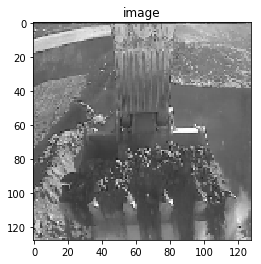

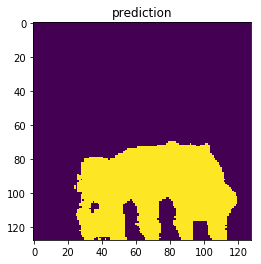

1_20180704-205500_1001n0_17024.png


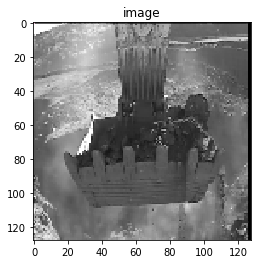

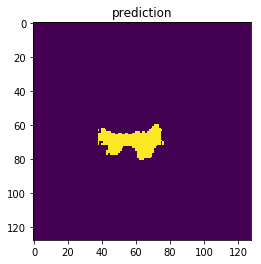

1_20180704-205500_1001n0_24226.png


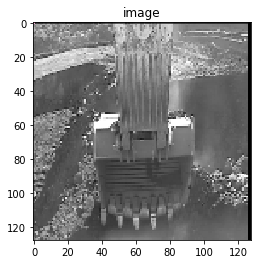

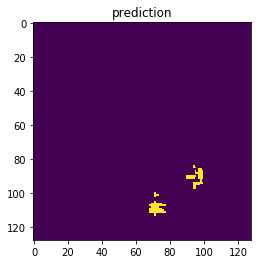

1_20180703-134700_1001n0_8767.png


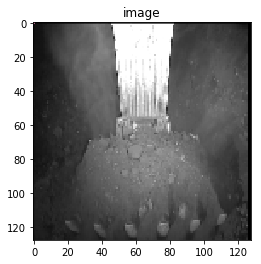

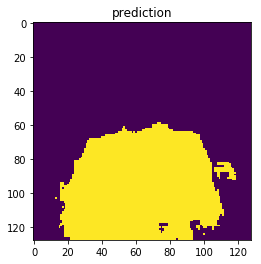

FMDL_2018.08.07_16.19.58.png


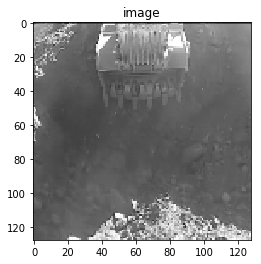

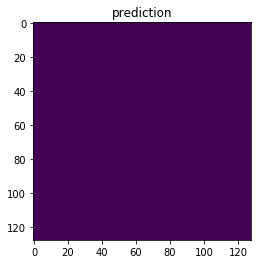

FMDL_2018.08.07_16.03.58.png


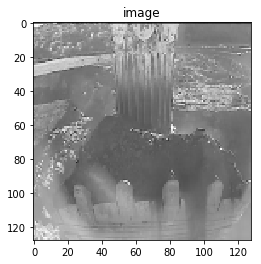

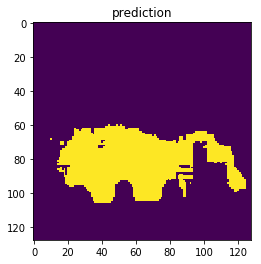

1_20180703-134700_1001n0_3680.png


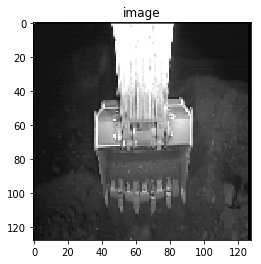

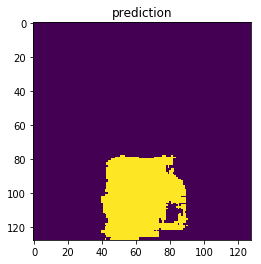

1_20180703-134700_1001n0_9030.png


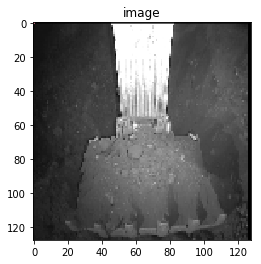

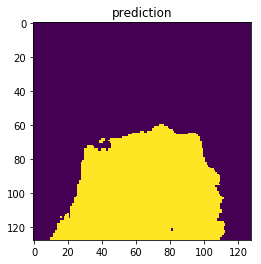

1_20180704-205500_1001n0_841.png


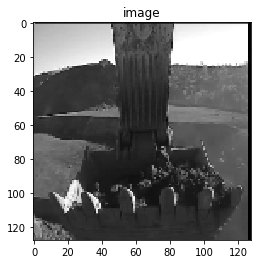

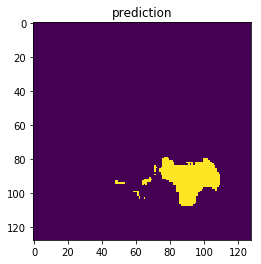

FMDL_2018.08.07_16.18.46.png


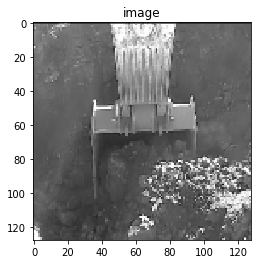

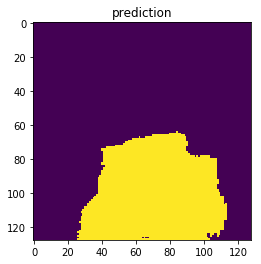

1_20180703-134700_1001n0_6669.png


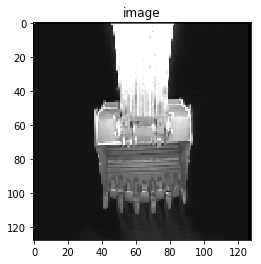

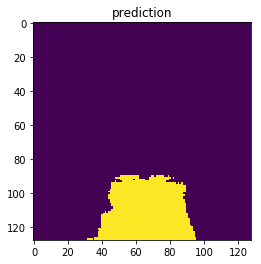

1_20180703-134700_1001n0_3744.png


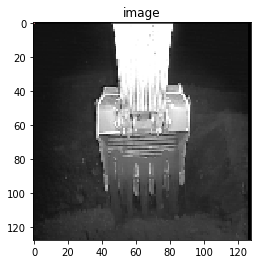

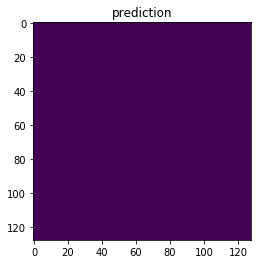

1_20180704-205500_1001n0_894.png


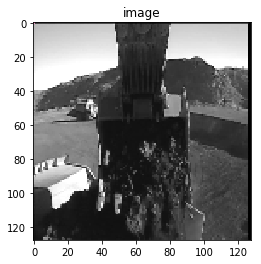

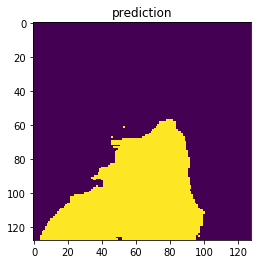

1_20180703-134700_1001n0_8751.png


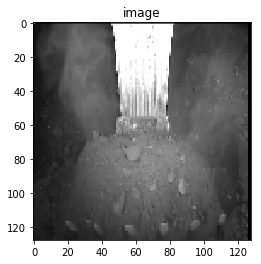

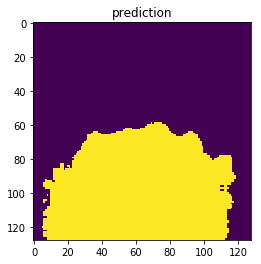

1_20180703-134700_1001n0_4144.png


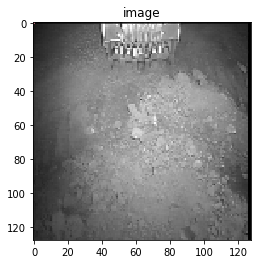

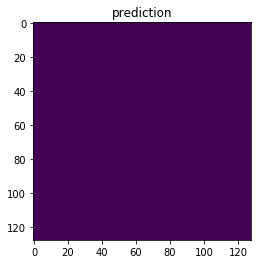

1_20180703-134700_1001n0_6941.png


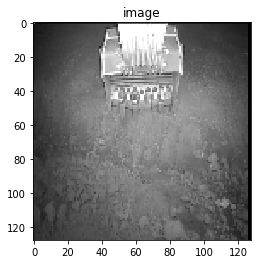

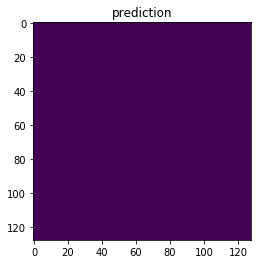

1_20180704-205500_1001n0_1134.png


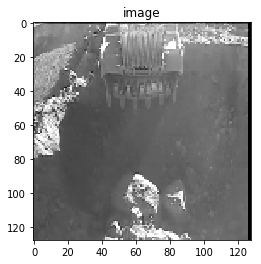

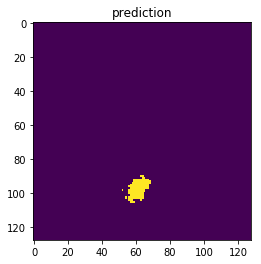

1_20180704-205500_1001n0_15487.png


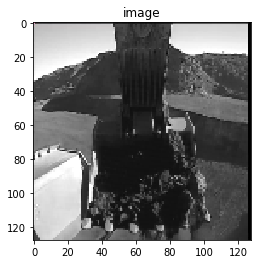

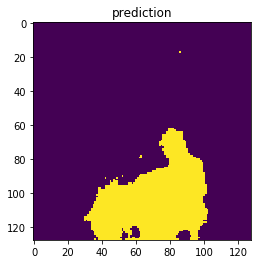

1_20180704-205500_1001n0_31.png


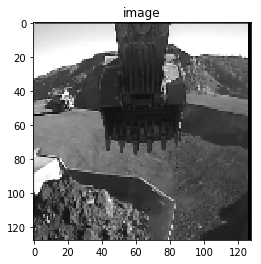

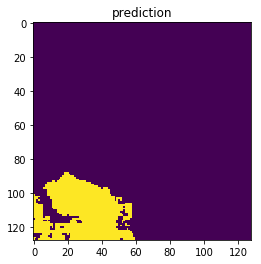

1_20180704-205500_1001n0_19123.png


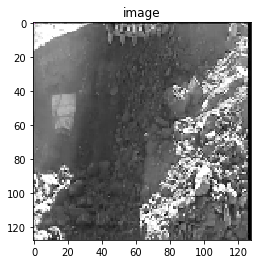

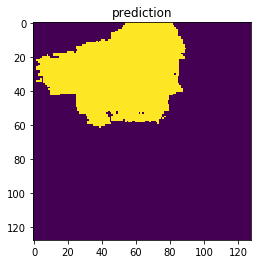

1_20180703-134700_1001n0_3712.png


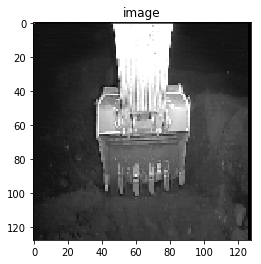

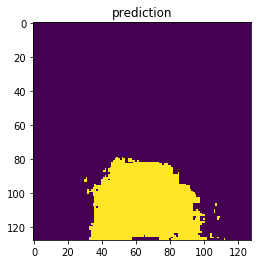

1_20180703-134700_1001n0_4080.png


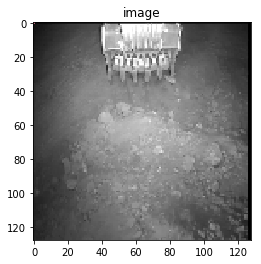

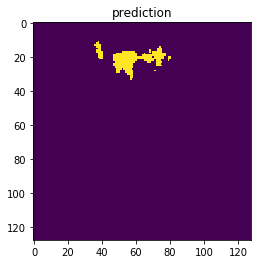

1_20180704-205500_1001n0_11231.png


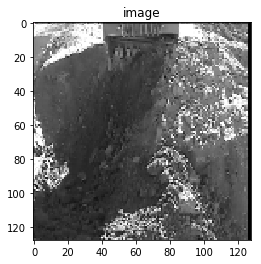

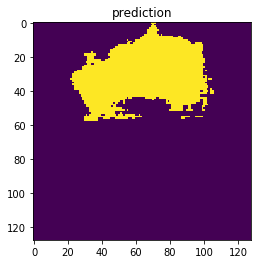

1_20180704-205500_1001n0_11832.png


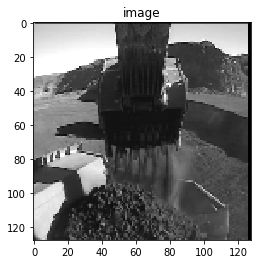

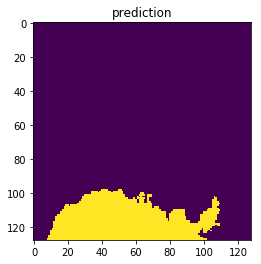

1_20180704-205500_1001n0_18845.png


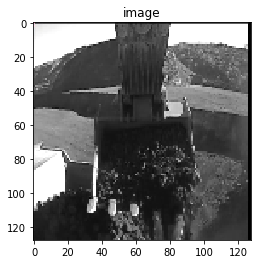

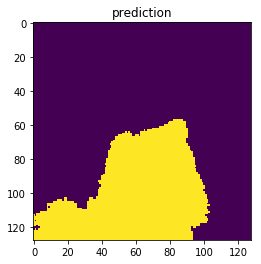

FMDL_2018.08.07_16.21.33.png


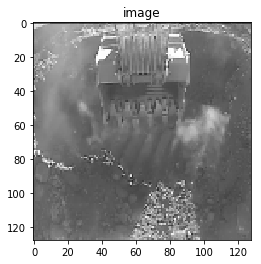

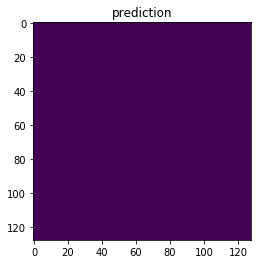

1_20180703-134700_1001n0_4064.png


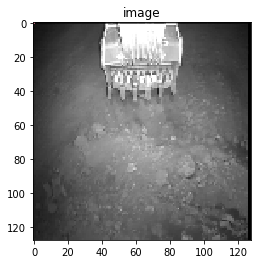

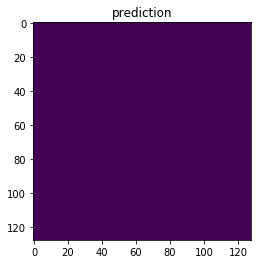

1_20180704-205500_1001n0_22710.png


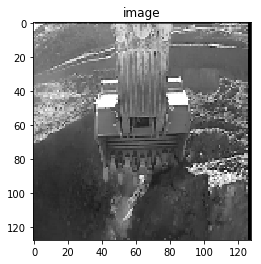

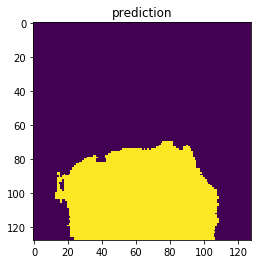

FMDL_2018.08.07_16.04.24.png


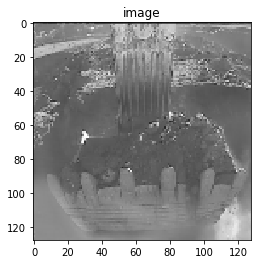

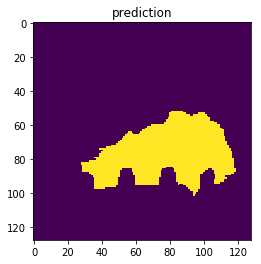

1_20180704-205500_1001n0_14153.png


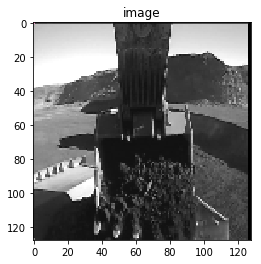

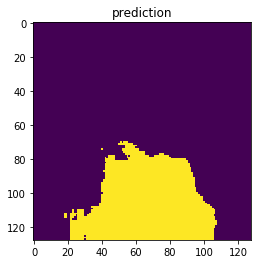

1_20180703-134700_1001n0_4688.png


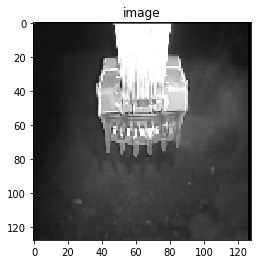

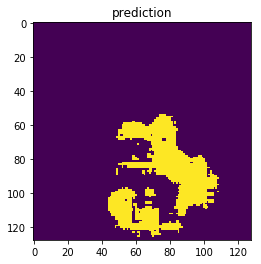

1_20180704-205500_1001n0_2275.png


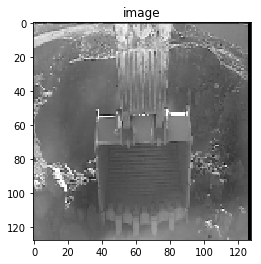

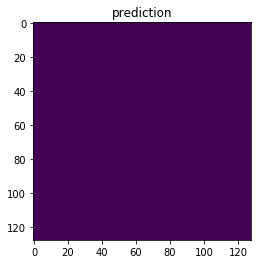

1_20180703-134700_1001n0_4048.png


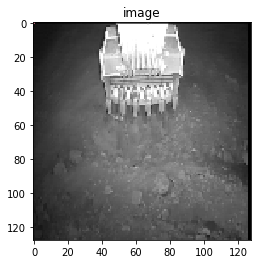

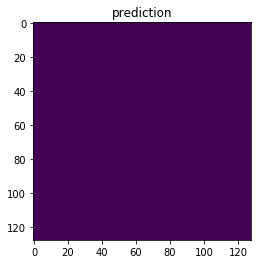

1_20180704-205500_1001n0_12652.png


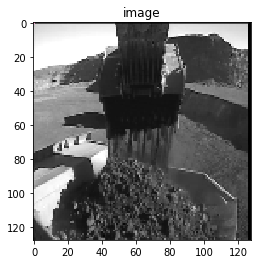

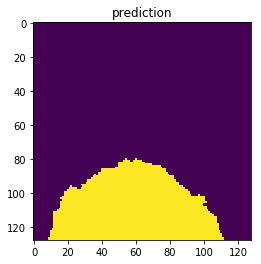

1_20180704-205500_1001n0_23589.png


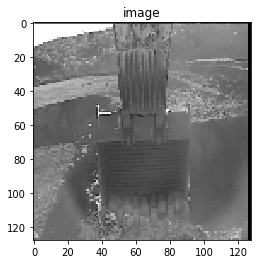

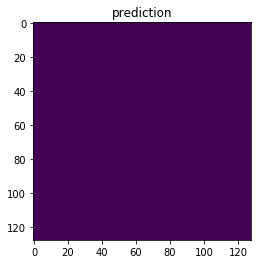

1_20180703-134700_1001n0_5286.png


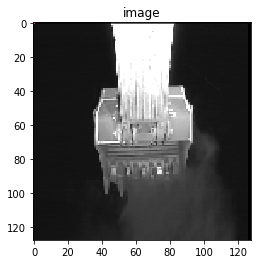

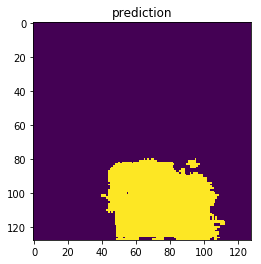

1_20180704-205500_1001n0_297.png


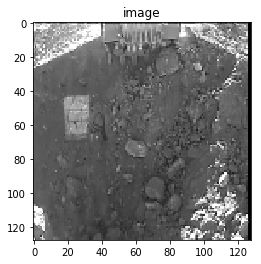

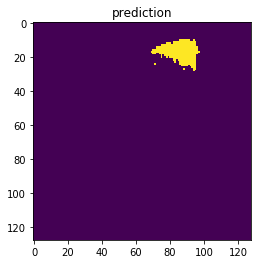

1_20180704-205500_1001n0_2395.png


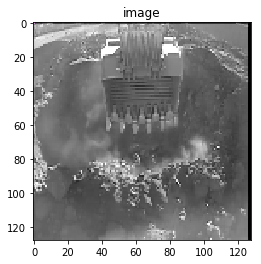

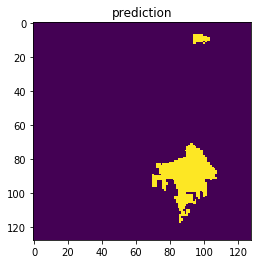

1_20180704-205500_1001n0_22195.png


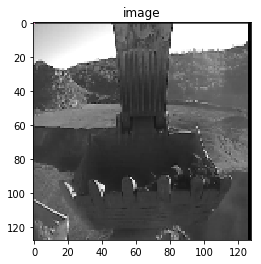

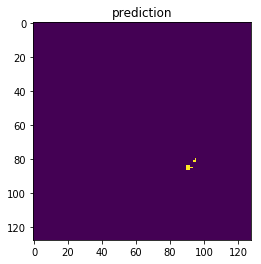

1_20180704-205500_1001n0_8197.png


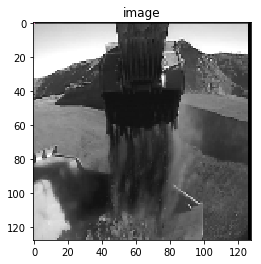

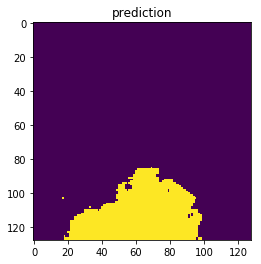

FMDL_2018.08.07_16.13.16.png


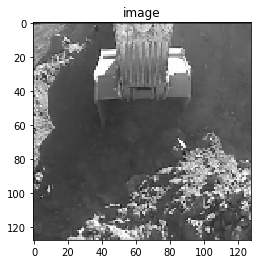

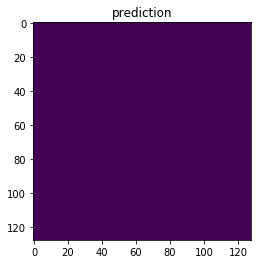

1_20180703-134700_1001n0_3664.png


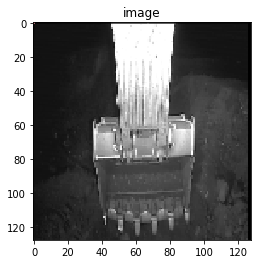

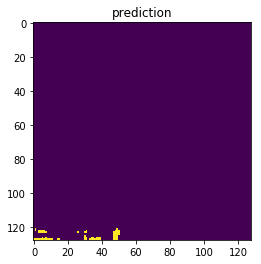

FMDL_2018.08.07_16.17.52.png


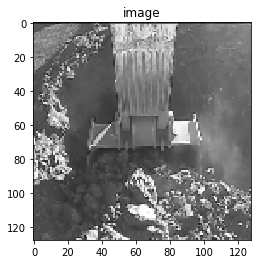

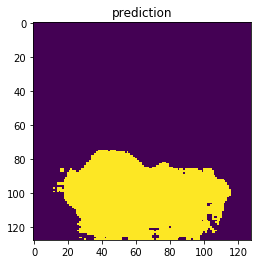

1_20180703-134700_1001n0_3984.png


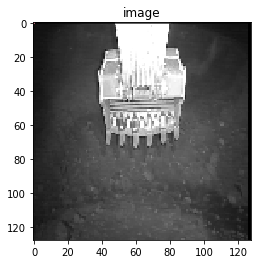

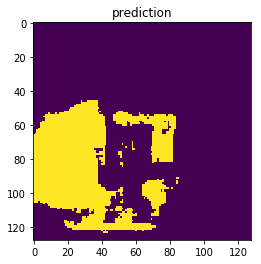

FMDL_2018.08.07_16.05.36.png


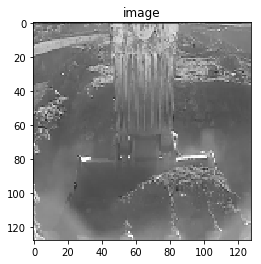

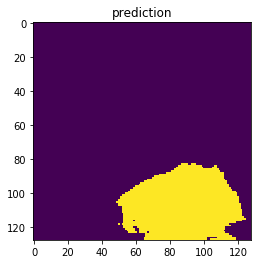

1_20180703-134700_1001n0_4784.png


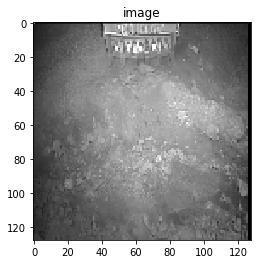

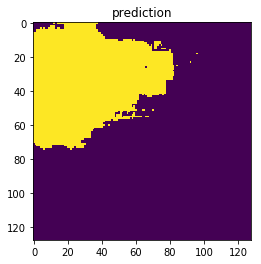

1_20180704-205500_1001n0_870.png


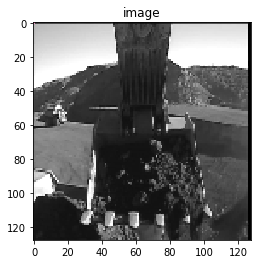

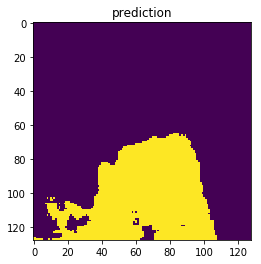

FMDL_2018.08.07_16.06.51.png


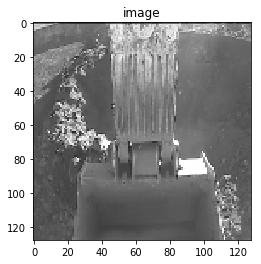

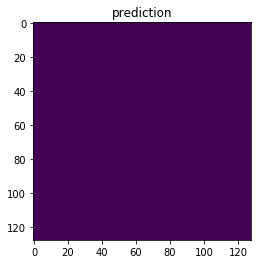

1_20180704-205500_1001n0_14072.png


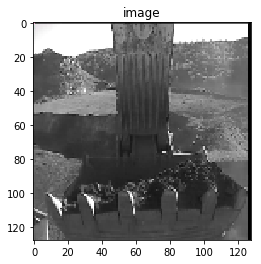

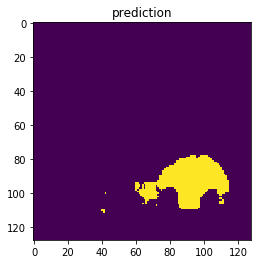

1_20180703-134700_1001n0_6685.png


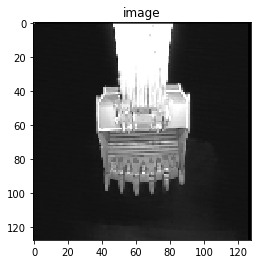

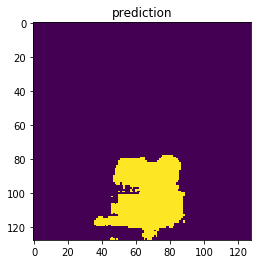

FMDL_2018.08.07_16.09.04.png


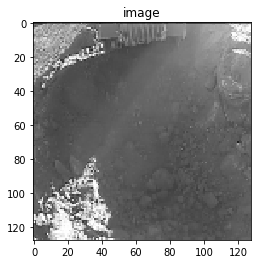

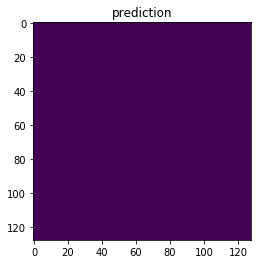

1_20180704-205500_1001n0_984.png


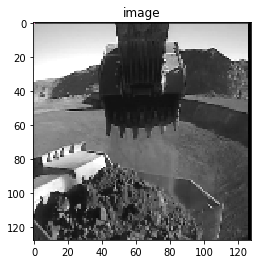

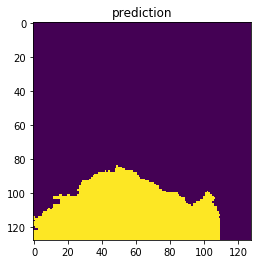

In [19]:
# making predictiosn from dictionary in order to save the results to disk

model = load_model('/home/hooman/backhoeOpticalScene/roiDelineators/try4-csvFrom-ssdTry3-withInapp-reducedNumberOfempyBuckets-BatchSize4/model-hsUNet-Backhoe-try4-1chan.h5', custom_objects={'mean_iou': mean_iou})

#pathToSavedResults = '/home/hooman/UNet/hsUnet_try14/predicted1chanImages/'


testPreds = {}
testPreds_t = {}
for imgId in testImages:
    testPreds[imgId] = model.predict(np.expand_dims(testImages[imgId], axis=0), verbose=0)
    testPreds_t[imgId] = (testPreds[imgId] > 0.5).astype(np.uint8)
    
    #imsave(pathToSavedResults + imgId, testPreds_t[imgId][0, :, :, 0])
    

    print(imgId)
    
    plt.imshow(testImages[imgId])
    plt.title('image')
    plt.show()

    plt.imshow(testPreds_t[imgId][0,:,:, 0])
    plt.title('prediction')
    plt.show()

In [43]:
# Reizing images labels and masks
pathToReadOrig = '/home/hooman/dataPreparation/hsTestSet/cropped/croppedMask_withInapp_mistakesRemoved/'
pathToSaveResized = '/home/hooman/dataPreparation/hsTestSet/cropped/28by28Masks/croppedMask_withInapp_mistakesRemoved/'

for n, fileName in tqdm(enumerate(os.listdir(pathToReadOrig)), total=len(os.listdir(pathToReadOrig))):
    
    label = imread(pathToReadOrig + fileName)
    resizedLabel = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    imsave(pathToSaveResized + fileName, resizedLabel)

100%|██████████| 183/183 [00:00<00:00, 415.57it/s]
